# Data Wrangling

Though the data I pulled from NYC data site came as a csv and was in relatively useable form, I still needed to perform additional cleaning to ensure my data was ready for analysis.

In [1]:
# Import the necessary packages and data
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

path = os.path.expanduser('~/Projects/capstone-two/data/raw/Harbor_Water_Quality.csv')
df = pd.read_csv(path, parse_dates=['Sample Date'])

C:\Users\Drew\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (5,6,10,11,12,13,20,21,26,27,35,38,40,51,53,59,60,61,64,65,67,68,76,82,83,88,94,95,97,98) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are dataype problems with certain columns, but before dealing with those, I first want to see what the dataframe looks like.

In [2]:
df.shape

(88366, 100)

In [3]:
df.head()

,Sampling Location,Duplicate Sample,Sample Date,Sample Time,Weather Condition (Dry or Wet),Top Sample Temperature (ºC),Bottom Sample Temperature (ºC),Site Actual Depth (ft),Top Sample Depth(ft),Bottom Sample Depth (ft),...,Oakwood BOD Top Sample (mg/L),Oakwood BOD Bottom Sample(mg/L),Oakwood Total Suspended Solid Top Sample (mg/L),Oakwood Total Suspended Solid Bottom Sample (mg/L),Top Turbidity( Nephelometric Turbidity Units),Bottom Turbidity YSI (Nephelometric Turbidity Units),Sampling Comment,Long,Lat,Type
0,BR5,NaN,2015-08-17,1:07 PM,Dry,24.68,NaN,13.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-73.8713,40.813667,Permanent
1,K2,NaN,1965-07-06,9:50 AM,NaN,22.8,22.2,21.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-74.153,40.641167,Permanent
2,N8,NaN,1909-07-16,4:10 PM,NaN,20,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-74.0455,40.606167,Permanent
3,N9,NaN,1972-07-27,9:22 AM,NaN,17.2,16.1,NaN,NaN,NaN,...,0.6,0.6,NaN,NaN,NaN,NaN,NaN,-73.9833,40.568333,Permanent
4,NC0,NaN,2014-02-26,10:45 AM,Dry,2.51,2.46,15.0,3.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Light snow,-73.9316,40.714961,Permanent


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88366 entries, 0 to 88365
Data columns (total 100 columns):
Sampling Location                                                                   88365 non-null object
Duplicate Sample                                                                    2929 non-null object
Sample Date                                                                         88365 non-null datetime64[ns]
Sample Time                                                                         84504 non-null object
Weather Condition (Dry or Wet)                                                      32498 non-null object
Top Sample Temperature (ºC)                                                         69920 non-null object
Bottom Sample Temperature (ºC)                                                      69147 non-null object
Site Actual Depth (ft)                                                              60162 non-null float64
Top Sample Depth(ft)              

In [5]:
df.describe()

,Site Actual Depth (ft),Top Sample Depth(ft),Bottom Sample Depth (ft),"CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)","CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L)",Percentage O2 Saturation Top Sample,Percentage O2 Saturation Bottom sample,Light Trans (% transparency) Top Sample,Light Trans (% transparency) Bottom Sample,Top Fluorometer (mg/m3),...,Bottom Bacteria # per C.C. 1909,Top Five-Day Biochemical Oxygen Demand(mg/L),Bottom Five-Day Biochemical Oxygen Demand(mg/L),Top PCB Plate Count (Thous/mL),Bottom PCB plate Count (Thous/mL),Bottom Coliform (Log No/mL),Oakwood BOD Top Sample (mg/L),Oakwood BOD Bottom Sample(mg/L),Oakwood Total Suspended Solid Top Sample (mg/L),Oakwood Total Suspended Solid Bottom Sample (mg/L)
count,60162.000000,27969.000000,27475.000000,20367.000000,18812.000000,22129.000000,20618.000000,16788.000000,15781.000000,18555.000000,...,635.000000,14354.000000,14290.000000,6654.000000,6645.000000,4160.000000,18646.000000,18564.000000,0.0,0.0
mean,34.193417,3.089239,31.046695,6.950473,6.069471,81.811070,69.511316,58.964913,58.450028,15.080308,...,5556.497638,2.548251,2.051372,2.376002,1.985658,1.476957,2.610243,2.395346,NaN,NaN
std,21.903431,1.076717,19.888996,2.898322,2.856763,30.539045,26.546844,20.532792,22.295995,23.359770,...,9855.976729,1.922383,1.637950,21.450678,28.440395,0.810886,1.548620,1.354373,NaN,NaN
min,0.000000,0.000000,1.000000,-1.120000,-9.990000,-15.900000,-51.670000,-22.860000,-41.970000,-99.000000,...,30.000000,-6.000000,0.000000,-100.000000,-100.000000,-1.000000,0.000000,0.000000,NaN,NaN
25%,18.000000,3.000000,16.400000,5.110000,4.390000,64.560000,55.572500,49.980000,50.290000,3.110000,...,1400.000000,1.600000,1.000000,0.073000,0.072000,1.000000,1.500000,1.400000,NaN,NaN
50%,28.000000,3.000000,24.000000,6.470000,5.660000,79.110000,70.280000,64.065000,65.300000,8.510000,...,3800.000000,2.000000,2.000000,0.230000,0.209000,1.000000,2.300000,2.100000,NaN,NaN
75%,46.000000,3.280000,41.000000,8.210000,7.240000,94.850000,83.700000,72.920000,73.590000,19.878000,...,6800.000000,3.000000,2.400000,0.800000,0.620000,2.000000,3.300000,3.100000,NaN,NaN
max,230.000000,23.000000,150.000000,28.560000,29.670000,374.220000,283.240000,131.730000,184.480000,294.700000,...,160000.000000,67.000000,66.000000,1200.000000,1800.000000,9.630000,17.200000,15.800000,NaN,NaN


In [6]:
len(df['Sampling Location'].unique())

5132

In [7]:
df['Sampling Location'].unique()

array(['BR5', 'K2', 'N8', ..., 'NR4-M1', 'NR1-M3', 'NR2-B2'], dtype=object)

There are 230 distinct locations, but I have a list of New York City Harbor Water Quality Survey Stations that is much shorter. The sites not listed in the following list are from older sampling events.

In [8]:
survey_stations = ['K1', 'K2', 'K3', 'K4', 'K5', 'K5A', 'K6',
                  'N1', 'N3B', 'N4', 'N5', 'N6', 'G2', 'N7', 'N8',
                  'N9', 'N16', 'NR1', 'E2', 'E4', 'E6', 'E7', 'E8',
                  'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'J1', 
                  'J2', 'J3', 'J5', 'J7', 'J8', 'J9A', 'J10', 'J11',
                  'J12', 'JA1', 'N9A', 'H3', 'J14', 'J16', 'AC1',
                  'AC1', 'AC2', 'BB2', 'BB4', 'BR1', 'BR3', 'BR5',
                  'CIC2', 'CIC3', 'F1', 'F5', 'FB1', 'FLC1', 'FLC2',
                  'GB1', 'GC3', 'GC4', 'GC5', 'GC6', 'HC1', 'HC2', 
                  'HC3', 'HR1', 'HR2', 'HR03', 'LN1', 'NC0', 'NC1',
                  'NC2', 'NC3', 'PB2', 'PB3', 'SP1', 'SP2', 'WC1',
                  'WC2', 'WC3'
                  ]
df = df[df['Sampling Location'].isin(survey_stations)]
df = df.reset_index(drop=True)

I don't want to look at data that is too old, so I am going to limit my dataset to readings from this millenium.

In [9]:
df = df[df['Sample Date'] >= datetime(2000, 1, 1)]
df = df.reset_index(drop=True)

I want to drop certain columns that do not have enough values or are not important to my question.

In [10]:
for col in df.columns:
    if 'Oakwood' in col:
        df = df.drop(columns=col)
    elif len(df[df[col].notnull()]) < 10000:
        df = df.drop(columns=col)
df = df.reset_index(drop=True)

Next I want to fix problematic columns

In [11]:
# Drop columns that I don't need
df = df.drop(['Current Direction (Current Direction)', 'Wind Direction (Wind Direction)',
              'Current Speed (knot)', 'Wind Speed (mph)', 'Sea State ', 'Type',
              'Enterococcus Top Sample Less Than or Greater Than Result'], axis=1)

In [12]:
# Fix 'Weather Condition' column
df['Weather Condition (Dry or Wet)'].unique()
df = df.replace(['Dry', 'Wet'], ['D', 'W'])

In [13]:
# Check which columns are numeric and create a list of object columns
obj_cols = []
ok_obj_cols = ['Sampling Location', 'Sample Date', 'Sample Time', 'Weather Condition (Dry or Wet)']
for col in df:
    if col not in ok_obj_cols:
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            print(col)
            obj_cols.append(col)

Top Sample Photosysthetically Active Radiation Reference (400-700nm light (uE/S)
Top Sample Par (uE/S m2)
Secchi Depth (ft)
Bottom PH
Top Fecal Coliform Bacteria (Cells/100mL)
Top Enterococci Bacteria (Cells/100mL)
Top Nitrate/Nitrite (mg/L)
Top Ammonium (mg/L)
Top Ortho-Phosphorus (mg/L)
Top Silica (mg/L)
Total Phosphorus(mg/L)
Bottom Total Suspended Solid (mg/L)
Top Active Chlorophyll 'A' (µg/L)
Long
Lat


In [14]:
# Fix Bottom TSS
df['Bottom Total Suspended Solid (mg/L)'] = df['Bottom Total Suspended Solid (mg/L)'].replace('.', np.nan)

In [15]:
# Fix Secchi Disk
df['Secchi Depth (ft)'] = df['Secchi Depth (ft)'].replace('3..5', '3.5')

In [16]:
for i in df['Long']:
    try:
        pd.to_numeric(i)
    except:
        df['Long'] = df['Long'].replace(i, np.nan)

In [17]:
# Fix Bottom PH
df['Bottom PH'] = df['Bottom PH'].replace('N', np.nan)

In [18]:
# Fix Top Active Chlorophyl
df['Top Active Chlorophyll \'A\' (µg/L)'] = df['Top Active Chlorophyll \'A\' (µg/L)'].replace('.', np.nan)

In [19]:
# Preprocess Top Fecal Col
df['Top Fecal Coliform Bacteria (Cells/100mL)'] = df['Top Fecal Coliform Bacteria (Cells/100mL)'].replace('TNTC', np.nan)

In [20]:
# Fix bacteria
bacteria = ['Top Fecal Coliform Bacteria (Cells/100mL)',
           'Top Enterococci Bacteria (Cells/100mL)']
def fix_commas(string):
    '''Removes commas from strings representing numbers
    with values in the thousands'''
    try:
        string = pd.to_numeric(string)
    except:
        string = string.replace(',', '')
    return string

for col in bacteria:
    try:
        df[col] = df[col].apply(fix_commas)
        df[col] = pd.to_numeric(df[col])
    except:
        print(col)

In [21]:
# fix some of total phos
df['Total Phosphorus(mg/L)'] = df['Total Phosphorus(mg/L)'].replace(['0..454', '0,968'], ['0.454', '0.968'])

In [22]:
df['Top Ortho-Phosphorus (mg/L)'] = df['Top Ortho-Phosphorus (mg/L)'].replace('.', np.nan)

In [23]:
# fix < sign
less_than_cols = ['Top Nitrate/Nitrite (mg/L)', 'Top Ammonium (mg/L)',
                 'Top Ortho-Phosphorus (mg/L)', 'Top Silica (mg/L)'
                 ]
def drop_less(string):
    '''Removes commas from strings representing numbers
    with values in the thousands'''
    try:
        string = pd.to_numeric(string)
    except:
        string = pd.to_numeric(string.replace('<', ''))
    return string


for col in less_than_cols:
    try:
        df[col] = df[col].apply(drop_less)
        df[col] = pd.to_numeric(df[col])
    except:
        print(col)

In [24]:
def col_strip(string):
    '''Strips strings of trailing spaces and returns
    stripped string or numeric value'''
    if type(string) == str:
        string = string.replace(' ', '')
    return string

In [25]:
for i, lat in enumerate(df['Lat']):
    try:
        pd.to_numeric(lat)
    except:
        lat_long = lat.split(',')
        if len(lat_long) == 2:
            df.loc[:, 'Lat'][i] = lat_long[0]
            if len(lat_long[1]) > 1:
                df.loc[:, 'Long'][i] = lat_long[1]


C:\Users\Drew\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Drew\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [26]:
for col in df:
    if col != 'Sample Date':
        try:
            df[col] = df[col].apply(col_strip)
            df[col] = pd.to_numeric(df[col])
        except:
            print(col)

Sampling Location
Sample Time
Weather Condition (Dry or Wet)
Total Phosphorus(mg/L)


There are some longitude and latitudes that are switched.

In [27]:
for i, long in enumerate(df['Long']):
    if long > 0:
        lat = long
        long = df.iloc[i]['Lat']
        df.at[i,'Lat'] = lat
        df.at[i,'Long'] = long

In [28]:
times = []
for i in df['Sample Time']:
    try:
        times.append(datetime.strptime(i, '%I:%M%p').time())
    except:
        times.append(np.nan)
df['Sample Time'] = times

In [29]:
# Drop duplicate measurements and columns that don't start being measured until 2005
drop_cols =  ['Winkler Method Top Dissolved Oxygen (mg/L)',  
              'Winkler Method Bottom Dissolved Oxygen (mg/L)', 
              'Percentage O2 Saturation Top Sample',  
              'Percentage O2 Saturation Bottom sample',
              'Total Phosphorus(mg/L)',
              'Top Nitrate/Nitrite (mg/L)'
             ]
for col in df:
    observation_df = df[df[col].notnull()]
    if observation_df['Sample Date'].min().year > 2002:
        drop_cols.append(col)
df = df.drop(columns=drop_cols)

Next I will examine the descriptive statistics of each column to identify values that are unexpectedly high or low. I looked at every column, but I will only include the problem column histograms here to save space.

In [30]:
prob_col = ['Site Actual Depth (ft)', 'Bottom Salinity  (psu)',
            'Bottom Conductivity (S/m)', 'Top Sigma-T (kg/m3)',
            'Top PH', 'Bottom PH', 'Top Enterococci Bacteria (Cells/100mL)',
            'Top Total Suspended Solid (mg/L)', 'Bottom Total Suspended Solid (mg/L)',
            'Top Active Chlorophyll \'A\' (µg/L)', 'Top Dissolved Organic Carbon (mg/L)'            
           ]

In [31]:
df[prob_col].describe()

,Site Actual Depth (ft),Bottom Salinity (psu),Bottom Conductivity (S/m),Top Sigma-T (kg/m3),Top PH,Bottom PH,Top Enterococci Bacteria (Cells/100mL),Top Total Suspended Solid (mg/L),Bottom Total Suspended Solid (mg/L),Top Active Chlorophyll 'A' (µg/L),Top Dissolved Organic Carbon (mg/L)
count,27886.000000,17720.000000,17528.000000,18558.000000,27625.000000,20673.000000,28903.000000,28503.000000,20709.000000,28474.000000,27732.000000
mean,28.630030,24.809579,4.090200,15.648450,7.649962,7.624497,463.049614,14.555029,17.591278,16.219485,3.359917
std,21.298745,3.794550,4.665498,4.181427,0.557454,0.574186,5052.267825,18.827639,21.909812,25.121986,1.290050
min,0.020000,0.200000,0.000000,-2.720000,0.330000,0.000000,0.000000,0.000000,0.000000,0.090000,0.500000
25%,14.000000,23.060000,2.980000,14.130000,7.400000,7.400000,2.000000,7.000000,7.400000,2.650000,2.700000
50%,21.000000,25.240000,3.500000,16.320000,7.620000,7.600000,6.000000,11.000000,12.000000,6.780000,3.200000
75%,40.000000,27.270000,3.900000,18.110000,7.870000,7.830000,32.000000,18.000000,21.000000,19.600000,3.800000
max,230.000000,44.730000,62.560000,38.940000,78.000000,75.000000,200000.000000,1805.000000,704.400000,770.000000,97.000000


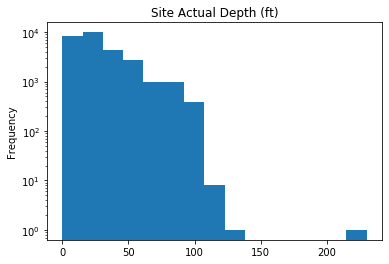

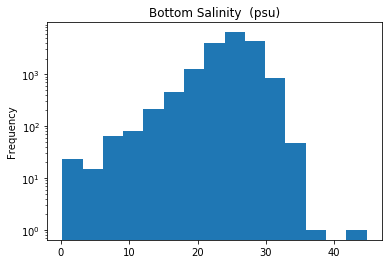

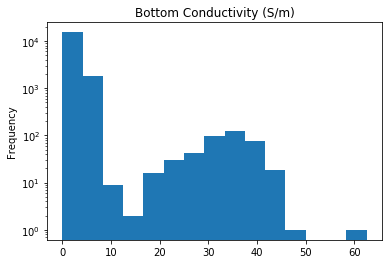

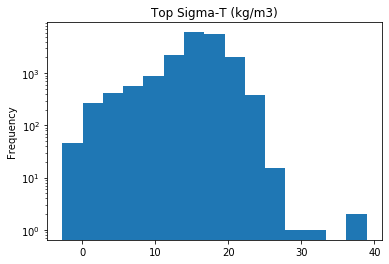

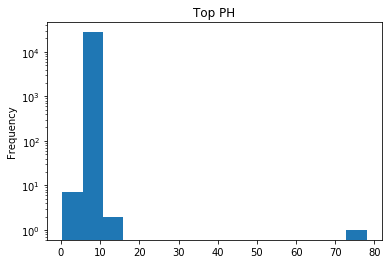

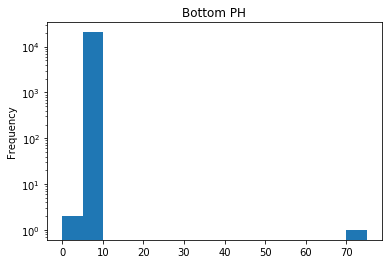

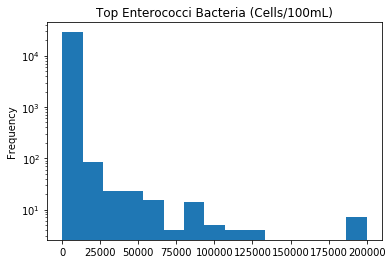

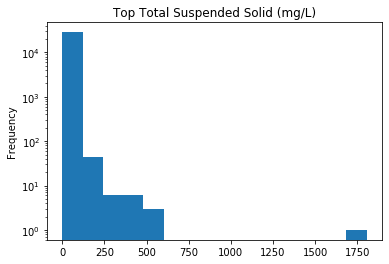

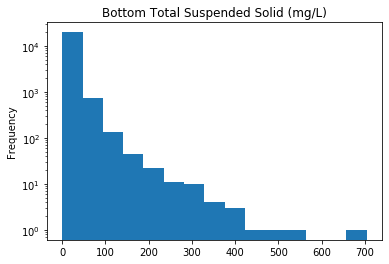

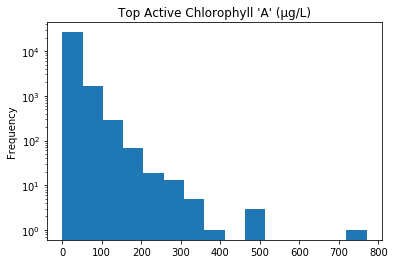

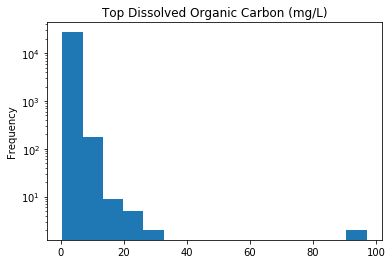

In [34]:
for col in prob_col:
    _ = plt.figure()
    _ = df[col].plot(kind='hist', bins=15)
    _ = plt.yscale('log')
    _ = plt.title(col)
    _ = plt.show()

In [35]:
df.nlargest(5, 'Site Actual Depth (ft)')

,Sampling Location,Sample Date,Sample Time,Weather Condition (Dry or Wet),Top Sample Temperature (ºC),Bottom Sample Temperature (ºC),Site Actual Depth (ft),Top Sample Depth(ft),Bottom Sample Depth (ft),Top Salinity (psu),...,Top Ammonium (mg/L),Top Ortho-Phosphorus (mg/L),Top Total Kjeldhal Nitrogen (mg/L),Top Silica (mg/L),Top Total Suspended Solid (mg/L),Bottom Total Suspended Solid (mg/L),Top Active Chlorophyll 'A' (µg/L),Top Dissolved Organic Carbon (mg/L),Long,Lat
26577,E6,2018-05-24,13:05:00,D,15.18,13.95,230.0,3.0,19.0,22.39,...,0.225,0.087,0.786,1.086,8.00,8.0,3.38,2.82,-73.860830,40.78550
26153,NC2,2018-06-05,09:52:00,D,18.19,17.77,129.0,3.0,16.0,21.04,...,0.466,0.092,1.234,2.340,11.00,19.0,10.00,3.01,-73.935500,40.72883
24454,E8,2019-04-03,10:52:00,D,NaN,NaN,120.2,NaN,NaN,NaN,...,0.260,0.032,0.304,0.836,5.00,NaN,2.78,2.21,-73.820500,40.80500
24741,E8,2019-03-06,11:17:00,D,NaN,NaN,120.0,NaN,NaN,NaN,...,0.165,0.032,0.560,0.161,8.00,NaN,36.20,2.23,-73.820500,40.80500
18105,E8,2007-03-19,11:28:00,W,2.51,1.57,114.0,3.0,107.0,24.59,...,0.257,0.060,0.812,0.910,5.75,5.0,12.30,3.66,-73.783667,40.80050


The max depth is almost twice as high as the next deepest location and is the only depth measurement from site `E6`. It is safe to assume that this point is an erroneous entry. After more exploration, it is clear that there was a decimal point was misplaced. The depth should be 23.0 not 230.

In [36]:
df.at[26577, 'Site Actual Depth (ft)'] = 23.0

In [37]:
df.nlargest(5, 'Bottom Salinity  (psu)')['Bottom Salinity  (psu)']

17051    44.73
19630    36.12
19157    35.34
202      35.23
19198    34.94
Name: Bottom Salinity  (psu), dtype: float64

While the maximum Bottom Salinity value is high, it does not appear to be an input error so I will keep it.

In [38]:
df.nlargest(5, 'Bottom Conductivity (S/m)')['Bottom Conductivity (S/m)']

17051    62.56
202      49.38
17208    43.66
22574    43.59
21503    43.47
Name: Bottom Conductivity (S/m), dtype: float64

While the maximum Bottom Conductivity value is high, it does not appear to be an input error so I will keep it. It is from the same sampling event as the max Bottom Salinity value.

Despite being an exceedingly high measurement, dissolved oxygen can have wildly different values, so I will keep this outlier as well.

In [39]:
df.nlargest(5, 'Top Sigma-T (kg/m3)')['Top Sigma-T (kg/m3)']

9413     38.94
23244    38.52
14813    33.20
4631     28.21
2403     27.17
Name: Top Sigma-T (kg/m3), dtype: float64

While high, these values appear to be outliers and not input errors.

In [40]:
df.nlargest(5, 'Top PH')['Top PH']

25444    78.00
1032     11.34
11150    11.16
25683     9.52
20573     9.11
Name: Top PH, dtype: float64

In [41]:
df.at[25444, 'Top PH'] = 7.80

In [42]:
df.nlargest(5, 'Bottom PH')['Bottom PH']

25344    75.00
21549     8.96
16150     8.92
13185     8.90
3130      8.88
Name: Bottom PH, dtype: float64

In [43]:
df.at[25344, 'Bottom PH'] = 7.50

In [44]:
df.nlargest(5, 'Top Enterococci Bacteria (Cells/100mL)')['Top Enterococci Bacteria (Cells/100mL)']

2907     200000.0
3423     200000.0
8761     200000.0
11484    200000.0
18824    200000.0
Name: Top Enterococci Bacteria (Cells/100mL), dtype: float64

Values don't appear to be errors.

In [45]:
df.nlargest(5, 'Top Total Suspended Solid (mg/L)')['Top Total Suspended Solid (mg/L)']

2843     1805.0
11396     536.0
1927      535.0
1412      488.0
18597     442.0
Name: Top Total Suspended Solid (mg/L), dtype: float64

In [46]:
df = df.drop(index=2843)

In [47]:
df.nlargest(5, 'Bottom Total Suspended Solid (mg/L)')['Bottom Total Suspended Solid (mg/L)']

2450     704.4
22987    527.5
4352     482.0
600      442.0
10874    388.0
Name: Bottom Total Suspended Solid (mg/L), dtype: float64

In [48]:
df.nlargest(5, 'Top Active Chlorophyll \'A\' (µg/L)')['Top Active Chlorophyll \'A\' (µg/L)']

12907    770.00
20323    480.56
27708    466.00
29637    466.00
21918    404.70
Name: Top Active Chlorophyll 'A' (µg/L), dtype: float64

In [49]:
df.nlargest(5, 'Top Dissolved Organic Carbon (mg/L)')['Top Dissolved Organic Carbon (mg/L)']

573      97.0
23319    95.8
28698    26.3
29676    26.3
28329    25.3
Name: Top Dissolved Organic Carbon (mg/L), dtype: float64

In [50]:
df = df.drop(index=[573, 23319])

In [51]:
df.reset_index(drop=True, inplace=True)

In [52]:
df.shape

(31002, 34)

In [53]:
outpath = os.path.expanduser('~/Projects/capstone-two/data/processed/Clean_Harbor_Water_Quality.csv')
df.to_csv(outpath)